In [120]:
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer


In [181]:
metadata = pd.read_csv('ml-data/movies_metadata.csv')
user_data = pd.read_csv('ml-data/ratings.csv')

/Users/franct04/IRFS/NLP_Hack/.env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
minimum_votes = metadata.vote_count.quantile(0.90)
average_rating = metadata.vote_average.mean()

def calculate_weighted_rating(row):
    num_votes = row['vote_count']
    rating  = row['vote_average']
    
    a = (num_votes/(num_votes+minimum_votes)) * rating
    b = (minimum_votes/(num_votes+minimum_votes))* average_rating
    return a+b

metadata_2 = metadata.loc[metadata['vote_count'] > minimum_votes]
metadata_2['weighted_rating'] = metadata_2.apply(calculate_weighted_rating, axis=1)

In [9]:
top_movies = metadata_2[['title','vote_count', 'vote_average', 'weighted_rating']].sort_values('weighted_rating', ascending=False).head(20)
top_movies.index.name  = 'id'

In [10]:
top_movies.to_csv('ml-data/top_movies.csv')

In [13]:
test,train = train_test_split(user_data)

## Random Recommendation

In [84]:
from tqdm import tqdm

# users = train.userId.unique()
users = []
for i in range(50000):
    users.append(i)

correct=0
incorrect=0
neutral = 0
not_reviewed = 0
movies = metadata['id'].unique()
for user in tqdm(users):
    user_ratings = test.loc[test['userId'] == user]
    movies_reviewed = user_ratings['movieId'].unique()
    for i in range(5):
        recommendation = int(random.choice(movies))
        if recommendation  in movies_reviewed:
            rating = float(user_ratings['rating'].loc[user_ratings['movieId'] == recommendation])
            if(rating >=3.5):
                correct+=1
            elif(rating< 2.5):
                incorrect+=1
            else:
                neutral+=1
        else:
            not_reviewed+=1


100%|██████████| 50000/50000 [20:02<00:00, 41.57it/s]


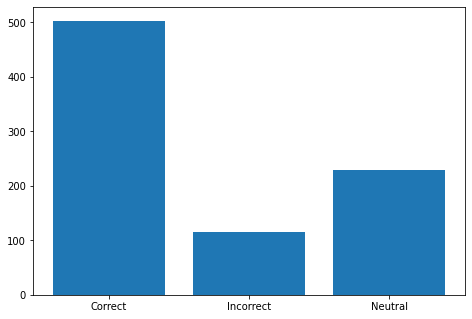

In [110]:


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Correct', 'Incorrect', 'Neutral']
values = [503,115,229] #[correct, incorrect, neutral]
ax.bar(labels,values)
plt.show()

## Most Popular

In [103]:
users = []
for i in range(50000):
    users.append(i)

correct=0
incorrect=0
neutral = 0
not_reviewed = 0

for user in tqdm(users):
    user_ratings = test.loc[test['userId'] == user]
    movies_reviewed = user_ratings['movieId'].unique()
    recommendations = top_movies.head(5).index.unique()
    for recommendation in recommendations:
        if recommendation  in movies_reviewed:
            rating = float(user_ratings['rating'].loc[user_ratings['movieId'] == recommendation])
            if(rating >=3.5):
                correct+=1
            elif(rating< 2.5):
                incorrect+=1
            else:
                neutral+=1
        else:
            not_reviewed+=1

100%|██████████| 50000/50000 [20:50<00:00, 40.00it/s]


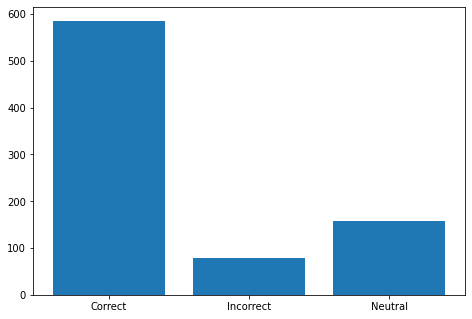

In [109]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Correct', 'Incorrect', 'Neutral']
values = [correct, incorrect, neutral]
ax.bar(labels,values)
plt.show()

# Content-Based Recommender

In [111]:
metadata['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
4    Just when George Banks has recovered from his ...
5    Obsessive master thief, Neil McCauley leads a ...
8    International action superstar Jean Claude Van...
Name: overview, dtype: object

In [114]:

tfidf = TfidfVectorizer(stop_words='english')

metadata['overview'] = metadata['overview'].fillna('')

tfidf_matrix = tfidf.fit_transform(metadata['overview'])

tfidf_matrix.shape

(45466, 75827)

In [115]:
tfidf.get_feature_names()[5000:5010]

['avails',
 'avaks',
 'avalanche',
 'avalanches',
 'avallone',
 'avalon',
 'avant',
 'avanthika',
 'avanti',
 'avaracious']

In [119]:
print(tfidf_matrix)

  (0, 17764)	0.13483149538639247
  (0, 4388)	0.1474882034218405
  (0, 38030)	0.10142919482788751
  (0, 21887)	0.10438761058719498
  (0, 19641)	0.13281884272823927
  (0, 48558)	0.10339358185033234
  (0, 59519)	0.13008016104455086
  (0, 12490)	0.12544427954397822
  (0, 51108)	0.13434817283119177
  (0, 29238)	0.10093917370354445
  (0, 50914)	0.09190797940163035
  (0, 39423)	0.11907123344715953
  (0, 1847)	0.140911774178889
  (0, 58571)	0.1135591886873686
  (0, 38693)	0.20627924682810617
  (0, 9874)	0.5028038686135609
  (0, 9087)	0.10635375129287977
  (0, 7491)	0.12380553184830104
  (0, 56872)	0.111248510865236
  (0, 28729)	0.13311522181618415
  (0, 39012)	0.08718689178959059
  (0, 67874)	0.14878284660693247
  (0, 3159)	0.41178365711725945
  (0, 73468)	0.4809827114790237
  (0, 38088)	0.10739705953465473
  :	:
  (45464, 26957)	0.0735096263170162
  (45464, 18919)	0.09271509240923416
  (45464, 18119)	0.07466631763708825
  (45464, 39012)	0.0682961777913538
  (45465, 16520)	0.32373307886945113


In [118]:
metadata.shape

(45466, 24)

In [121]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [122]:
cosine_sim.shape

(45466, 45466)

In [123]:
cosine_sim[1]

array([0.01504121, 1.        , 0.04681953, ..., 0.        , 0.02198641,
       0.00929411])

In [124]:
indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()

In [126]:
indices.head()

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64

In [159]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:10]

    print(sim_scores)
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]


def get_movie_id(name):
    return metadata['id'].loc[metadata['title'] == name]

def get_movie_name(ID):
    return metadata['title'].loc[metadata['id'] == ID]

In [140]:
get_recommendations('The Shawshank Redemption')

[(16947, 0.1608523950901097), (6548, 0.15978243595788563), (39141, 0.15892514976532443), (11327, 0.14927072164604832), (36701, 0.14321760531072364), (17446, 0.1374482688985937), (9391, 0.13716314836023943), (34185, 0.13586587493438596), (9225, 0.13570896649009745)]


16947                   They Made Me a Fugitive
6548                                Civil Brand
39141                         Seven Times Seven
11327                               Brute Force
36701                            Women's Prison
17446                           Girls in Prison
9391                                    In Hell
34185                   Women's Prison Massacre
9225     Female Prisoner Scorpion: Jailhouse 41
Name: title, dtype: object

100%|██████████| 5/5 [00:00<00:00, 23.04it/s]

69844
Series([], Name: title, dtype: object)
64
5740    Talk to Her
Name: title, dtype: object
2875
Series([], Name: title, dtype: object)


In [179]:
metadata.loc[metadata['id'] == '69844']

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count


In [178]:
train.loc[train['userId'] == 1]

,userId,movieId,rating,timestamp
1,1,147,4.5,1425942435
17,1,69844,5.0,1425942139
16,1,68358,5.0,1425941464
6,1,2762,4.5,1425941300
22,1,92439,5.0,1425941424
15,1,59315,5.0,1425941502


# Genre based

In [287]:
genres = pd.read_csv('ml-latest/movies.csv')

In [288]:
genres['genres'] = genres['genres'].apply(lambda x : x.replace('|', " "))
no_genres = list(genres['movieId'].loc[genres['genres'] == '(no genres listed)'])
genres['genres'] = genres['genres'].fillna('')


In [269]:
# genres['index'] = genres['movieId']
# genres = genres.set_index('index')


In [289]:
tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(genres['genres'])

tfidf_matrix.shape

(58098, 23)

In [290]:
tfidf.get_feature_names()[0:25]

['action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'fi',
 'film',
 'genres',
 'horror',
 'imax',
 'listed',
 'musical',
 'mystery',
 'noir',
 'romance',
 'sci',
 'thriller',
 'war',
 'western']

In [291]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [292]:
cosine_sim.shape

(58098, 58098)

In [293]:
cosine_sim[1]

array([0.82451125, 1.        , 0.        , ..., 0.        , 0.25906638,
       0.        ])

In [294]:
indices = pd.Series(genres.index, index=genres['movieId']).drop_duplicates()

69

In [319]:
def get_recommendations(movieID, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[movieID]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:15]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return genres['movieId'].iloc[movie_indices]


def get_movie_id(name):
    return genres['movieId'].loc[genres['title'] == name]

def get_movie_name(ID):
    return genres['title'].loc[genres['movieId'] == ID]

In [323]:
get_recommendations(69844)

20052     98203
17608     88125
25012    115669
20772    100882
15388     78105
7769       8368
14999     74789
20212     98809
20788    101025
22384    106489
12002     54001
32           33
10620     40815
16274     81834
Name: movieId, dtype: int64

In [359]:
users = []
for i in range(50000):
    users.append(i)

correct=0
incorrect=0
neutral = 0
not_reviewed = 0

for user in tqdm(users):
    user_ratings = user_data.loc[user_data['userId'] == user]
    top_rating=  user_ratings.rating.max()
    top_two = []
    if(top_rating> 2):
        top_rated_id = user_ratings['movieId'].loc[user_ratings['rating']== top_rating].unique()[0]
        reviewed = user_ratings['movieId'].unique()
        recommended_movies = get_recommendations(top_rated_id).unique()
        for movie in recommended_movies:
            if movie in reviewed:
                rating = float(user_ratings['rating'].loc[user_ratings['movieId'] == movie])
                if(rating >=3.5):
                    correct+=1
                elif(rating< 2.5):
                    incorrect+=1
                else:
                    neutral+=1
            else:
                not_reviewed+=1

        

100%|██████████| 50000/50000 [1:08:21<00:00, 12.19it/s]   


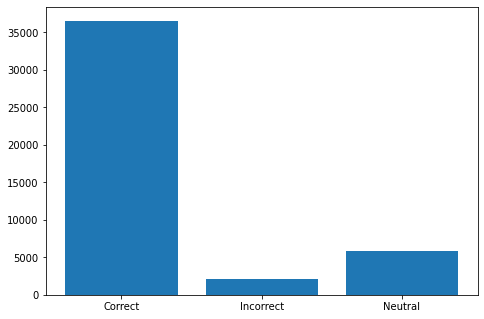

In [360]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Correct', 'Incorrect', 'Neutral']
values = [correct, incorrect, neutral]
ax.bar(labels,values)
plt.show()

In [343]:
user_data

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990
